In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm  import tqdm
import dataprocessor.processor as data_loader
import dataprocessor.util as data_util
import models.model as model_loader
import models.configure as model_config

import json


'''To resolve Running the Tensorflow 2.0 code gives 
   ValueError: tf.function-decorated function tried to create
   variables on non-first call'. What am I doing wrong?
'''
tf.config.run_functions_eagerly(True)

!!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

[]

In [2]:
#loading abc music data
songs = data_loader.load_training_data()
print(songs[0])

X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [3]:
# Convert the ABC notation to audio file and listen to it
data_loader.play_song(songs[0])

In [4]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs) 

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


In [5]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
#   we can evaluate `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)
print(len(char2idx), len(idx2char))

83 83


In [6]:
#to store the char
with open('char2idx.json', 'w') as fp:
    json.dump(char2idx, fp)

In [7]:
idx2char

array(['\n', ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.', '/', '0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       '[', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
       'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v',
       'w', 'x', 'y', 'z', '|'], dtype='<U1')

In [8]:
vectorized_songs = data_loader.vectorize_string(songs_joined,char2idx)

In [9]:
# print(vectorized_songs.argmax)

In [10]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [11]:
# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_songs, 10, 2)
if not data_loader.test_batch_func_types(data_loader.get_batch, test_args) or \
   not data_loader.test_batch_func_shapes(data_loader.get_batch, test_args) or \
   not data_loader.test_batch_func_next_step(data_loader.get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [12]:
#configure the vocabulary size
model_config.vocab_size = len(vocab)
print(model_config.vocab_size)

83


In [13]:
# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = model_loader.build_model(model_config.vocab_size, model_config.embedding_dim, model_config.rnn_units, model_config.batch_size)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           21248     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


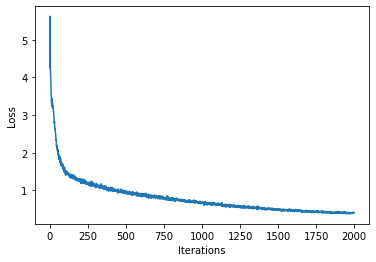

100%|██████████| 2000/2000 [1:39:50<00:00,  3.00s/it]

[4.419149, 4.249798, 5.6248217, 4.9180055, 4.254736, 4.0433626, 3.9602768, 3.8172407, 3.71932, 3.4950402, 3.4334345, 3.3448718, 3.318396, 3.4511895, 3.4005868, 3.4182706, 3.2384284, 3.314865, 3.2001295, 3.2541864, 3.1901581, 3.257213, 3.1456585, 3.1154516, 3.1005056, 3.072889, 3.0456207, 2.9855192, 2.9070413, 2.8853576, 2.789519, 2.8324773, 2.7131848, 2.693318, 2.6325665, 2.6407197, 2.5517392, 2.5278938, 2.520975, 2.447177, 2.404656, 2.3407648, 2.3506124, 2.2553773, 2.1752348, 2.207335, 2.1670203, 2.172468, 2.1059775, 2.14256, 2.045539, 2.0570986, 2.030004, 1.9508147, 2.085116, 1.9836289, 1.9407572, 1.9504178, 1.904624, 1.9408088, 1.8476666, 1.8745172, 1.9300256, 1.8065972, 1.9001187, 1.8126116, 1.8866904, 1.7892233, 1.8440509, 1.7319171, 1.82824, 1.8492327, 1.752655, 1.6615555, 1.7597104, 1.7675418, 1.7477851, 1.6554084, 1.707622, 1.6447549, 1.6846386, 1.7238086, 1.6495557, 1.7079773, 1.6827961, 1.6631131, 1.6561886, 1.5636059, 1.6723983, 1.6373336, 1.5802188, 1.6311606, 1.5268342, 1.

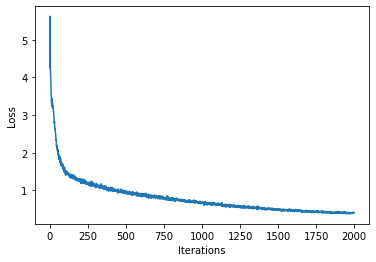

In [15]:
history = []
plotter = data_util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
optimizer = model_loader.define_optimizer(model_config.learning_rate)  
#TRAINING 
for iter in tqdm(range(model_config.num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = data_loader.get_batch(vectorized_songs, model_config.seq_length, model_config.batch_size)
  loss = model_loader.train_step(model,x_batch, y_batch,optimizer)

  # Update the progress bar
  print("{}'s iter loss is {}".format(iter,loss.numpy().mean()))
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(model_config.checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(model_config.checkpoint_prefix)
print(history)